In [7]:
import tensorflow as tf
import gym
import numpy as np
import matplotlib.pyplot as plt


class ActorCritic:
    
    def __init__(self, input_shape, num_actions, discount=0.95):

        self.actor = tf.keras.models.Sequential([
                        tf.keras.layers.Dense(16, activation='relu', input_shape=input_shape),
                        tf.keras.layers.Dense(32, activation='relu'),
                        tf.keras.layers.Dense(num_actions, activation='softmax')])
        
        self.critic = tf.keras.models.Sequential([
                        tf.keras.layers.Dense(16, activation='relu', input_shape=input_shape),
                        tf.keras.layers.Dense(32, activation='relu'),
                        tf.keras.layers.Dense(1, activation='linear')])

        self.actor_optimizer = tf.keras.optimizers.Adam()
        self.critic_optimizer = tf.keras.optimizers.Adam()
        self.num_actions = num_actions
        self.discount = discount

    def forward(self, state):
        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)
        policy_dist = self.actor(state)
        value = self.critic(state)

        return tf.squeeze(policy_dist), tf.squeeze(value)

    def train_episode(self, env, max_steps):

        state = env.reset()
        rewards = []
        values = []
        log_probs = []

        with tf.GradientTape(persistent=True) as tape:

            for step in range(max_steps):

                policy_dist, value = self.forward(state)
                action = np.random.choice(self.num_actions, p=policy_dist.numpy())

                state, reward, done, _ = env.step(action)
                log_prob = tf.math.log(policy_dist[action] + 1e-5)

                rewards.append(reward)
                values.append(value)
                log_probs.append(log_prob)

                if done:
                    Qval = 0
                    break
                elif step == max_steps - 1:
                    _, Qval = self.forward(state)
                    Qval = Qval
                    break
            
            Qvals = np.zeros_like(values)
            for t in reversed(range(len(values))):
                Qval = rewards[t] + self.discount * Qval
                Qvals[t] = Qval 
            
            
            advantages = []
            for Qval, value in zip(Qvals, values):
                advantages.append(Qval - value)

            actor_loss = 0
            for log_prob, advantage in zip(log_probs, advantages):
                actor_loss -= (log_prob * advantage) / len(log_probs)
                     
            critic_loss = 0.5 * tf.math.reduce_mean(tf.math.pow(advantages, 2))

            ac_loss = actor_loss + critic_loss
        
        actor_grads, critic_grads = tape.gradient(ac_loss, [self.actor.trainable_variables, self.critic.trainable_variables])

        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

        return sum(rewards)

-200.94328607172645 -118.8 -63.0


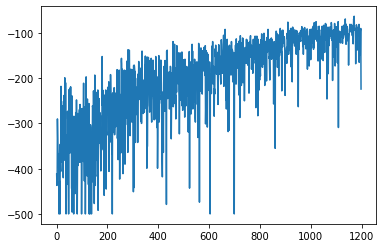

In [8]:
from IPython import display
import time
if __name__ == '__main__':

    env = gym.make('Acrobot-v1')

    actor_critic = ActorCritic(env.observation_space.shape, env.action_space.n)
    total_rewards = []
    
    for episode in range(1200):
        try:
            print(f'In Episode {episode}')

            reward = actor_critic.train_episode(env, 10000)
            display.clear_output(wait=True)
            total_rewards.append(reward)

            print(np.mean(total_rewards), np.mean(total_rewards[-10:]), max(total_rewards))   
            
    
        except KeyboardInterrupt:
            plt.plot(list(range(len(total_rewards))), total_rewards)
            plt.show()
            actor_critic.actor.save('actor.h5')
            time.sleep(5)

    plt.plot(list(range(len(total_rewards))), total_rewards)
    plt.show()
    actor_critic.actor.save('actor.h5')


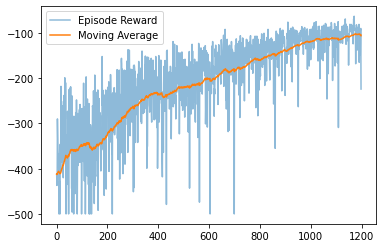

In [10]:
# Calculating EMA
prev = 0
mva = []

k = 2 / (101)

for el in total_rewards:

    if prev != 0:
        pres = prev * (1 - k) + el * k
    else:
        pres = el 
    prev = pres
    mva.append(pres)
plt.plot(list(range(len(total_rewards))), total_rewards, alpha=0.5, label="Episode Reward")
plt.plot(list(range(len(mva))), mva, label="Moving Average")
plt.legend()